# Human Activity Recognition
### Dataset: [Dataset link](https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset?resource=download)
### Task: multiclass classification

### Commentary: 
This dataset was used with many ML methods. I would like to draw attention to how data can be processed.
Instead of DL letting to figuring the patterns out I will use simple ML methods without hypertuning. Moreover, making ANN with linear activation function in first layer with features  also as previous function is in first layer is just a filtration. Maybe this is a good point for next notebook to show what weights was used and how can we interpret it as filters.

In [1]:
import numpy as np
import pandas as pd
import math
import os
import scipy.signal as sig
import scipy.stats as stats
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

## Idea:
We will get some features from 1 second window. In other words, I'll take 50 points and transform them into features and I won't use original data. Why 50 samples, because 50 samples is gathered in 1 second.
Below you can find some functions for feature extraction

In [2]:
def amplitude(data, col_name_prefix):
    '''
    Even the same activity will be done 100 times in the same way
    if the smartphone was placed differently we can get significant differences taking look at single axis
    taking look at amplitude makes us losing view on orientation of smartphone
    but we get clear information of changes unrelated to axes.
    '''
    data[col_name_prefix+'_amp'] = np.sqrt(data[col_name_prefix+'.x']**2 +
                                           data[col_name_prefix+'.y']**2 +
                                           data[col_name_prefix+'.z']**2)
    return data
def crossing_count(signalx):
    '''
    how many times within window signal has crossed mean value
    '''
    signalx = signalx
    cross = 0 #initial state
    m = np.mean(signalx)
    for index in range(1,len(signalx)):
        previous = signalx[index-1] > m
        current = signalx[index] > m
        if previous != current:
            cross += 1   
    return cross/len(signalx)


def psd_freq(signalx):
    '''
    mfreq is at which 50% of total energy(without constant component) is located by cumsum
    maxfreq is frequency which has highest amplitude
    '''
    f, Pxx_den = sig.periodogram(signalx, 50)
    f = np.delete(f, 0)
    Pxx_den = np.delete(Pxx_den, 0)
    norcumsum = np.cumsum(Pxx_den)/np.sum(Pxx_den)
    mfreq = min(f[norcumsum>0.5])
    maxfreq = f[np.argmax(Pxx_den)]
    return mfreq, maxfreq

def weight(signal):
    '''
    weight is like center of mass. 
    Every sample is equally important and 
    we would like to know where is center of the signal in time domain.
    '''
    norcumsum = np.cumsum(signal) / np.sum(signal)
    x = np.arange(0, len(signal))
    return min(x[norcumsum>0.5], default=0)


def flatness_entropy(signalx): 
    '''
    Entropy in frequency domain
    '''
    f, Pxx_den = sig.periodogram(signalx, 50)
    f = np.delete(f, 0) #we don't want constant component
    Pxx_den = np.delete(Pxx_den, 0)
    Pxx_den = Pxx_den/np.sum(Pxx_den)
    SpecEnt = 0
    for val in Pxx_den:
        SpecEnt += val*np.log(val)
    SpecEnt = -1 / np.log(len(Pxx_den)) * SpecEnt
    return SpecEnt

In [3]:
def new_features(data, win_len_s=1):
    [b,a] = sig.butter(2,10, fs=50) # filtration of singal, mainly we reduce the noise.(noise in freq up to 10Hz stays)
    data = data.apply(lambda x : sig.filtfilt(b,a,x)) #why filtfilt? since we want to keep phase in right place
    win_len = round(win_len_s * 50) # of how amny samples our window consists
    features = pd.DataFrame()
    labels = ['rotationRate_amp', 'userAcceleration_amp', 'gravity_hil', 'rotationRate_hil', 'userAcceleration_hil']
    labels += list(data)
    for stop in range(win_len,len(data.index),win_len):
        d_row = {}
        temp = data.iloc[(stop-win_len):(stop)]
        for label in list(temp):
            d = {'mean'+'_'+label: np.mean(temp[label].to_numpy()),
                 'std'+'_'+label: np.std(temp[label].to_numpy()),
                 'crossing'+'_'+label: crossing_count(temp[label].to_numpy()),
                 'jitter'+'_'+label: np.sum(np.abs(np.diff(temp[label].to_numpy())))/len(temp.index),
                 'kurtosis'+'_'+label: stats.kurtosis(temp[label].to_numpy()),
                 'skew'+'_'+label: stats.skew(temp[label].to_numpy()),
                 'iqr'+'_'+label: stats.iqr(temp[label].to_numpy()),
                 'rms'+'_'+label: np.sqrt(np.sum(temp[label]**2))/len(temp.index),
                 'specent'+'_'+label: flatness_entropy(temp[label].to_numpy()),
                 'max'+'_'+label: max(temp[label]),
                 'min'+'_'+label: min(temp[label]),
                 'median'+'_'+label: np.median(temp[label].to_numpy()),
                 'weight'+'_'+label: weight(temp[label].to_numpy())
                }
            d_row = {**d_row, **d}
        features = features.append(d_row, ignore_index=True)
    return features

As reference we will use as features just those 50 samples as input

In [4]:
def lag_features(data, win_len_s=1):
    result = pd.DataFrame()
    win_len = round(win_len_s * 50)
    for stop in range(win_len,len(data.index),win_len):
        temp = data.iloc[(stop-win_len):(stop)]
        cols_name = list(temp)
        d_row={}
        for col_name in cols_name:
            for i in range(0,win_len):
                d={col_name+'_lag_'+str(i): temp[col_name].iloc[i]}
                d_row={**d_row, **d}
        result=result.append(d_row, ignore_index=True)
    return result

Time to get some data

In [5]:
dir_path = 'A_DeviceMotion_data'
folders = []
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    folders.append(path)
print(folders)
activity = [row[0:3] for row in folders]
activity = list(dict.fromkeys(activity))
print(activity)

['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']
['dws', 'jog', 'sit', 'std', 'ups', 'wlk']


And processed them

In [6]:
first_data = []
short_summary = pd.DataFrame(columns=['Subject', 'n_trial', 'activity', 'rows', 'time_min'])
post_data=pd.DataFrame()
raw_data=pd.DataFrame()
for folder in folders:
    label = folder[0:3]
    group_id = int(folder[4:])
    catalog = os.path.join(dir_path, folder)
    for path in os.listdir(catalog):
        temp_path = os.path.join(catalog, path)
        subject = int(path[4:-4])
        temp = pd.read_csv(temp_path, index_col=0)
        temp_lag = lag_features(temp, 1)
        temp_feature = new_features(temp, 1)
        temp_lag['label'] = label
        temp_feature['label'] = label
        print(f"label: {label}, measurment_gorup: {group_id}, subject_nr: {subject}")
        short_summary = short_summary.append({'Subject' : subject,
                                              'n_trial' : folder[4:],
                                              'activity' : label,
                                              'rows' : len(temp.index),
                                              'time_min': len(temp.index)/50/60},
                                             ignore_index = True)
        first_data.append([label, subject, temp])
        raw_data = raw_data.append(temp_lag)
        post_data = post_data.append(temp_feature)

label: dws, measurment_gorup: 1, subject_nr: 1
label: dws, measurment_gorup: 1, subject_nr: 10
label: dws, measurment_gorup: 1, subject_nr: 11
label: dws, measurment_gorup: 1, subject_nr: 12
label: dws, measurment_gorup: 1, subject_nr: 13
label: dws, measurment_gorup: 1, subject_nr: 14
label: dws, measurment_gorup: 1, subject_nr: 15
label: dws, measurment_gorup: 1, subject_nr: 16
label: dws, measurment_gorup: 1, subject_nr: 17
label: dws, measurment_gorup: 1, subject_nr: 18
label: dws, measurment_gorup: 1, subject_nr: 19
label: dws, measurment_gorup: 1, subject_nr: 2
label: dws, measurment_gorup: 1, subject_nr: 20
label: dws, measurment_gorup: 1, subject_nr: 21
label: dws, measurment_gorup: 1, subject_nr: 22
label: dws, measurment_gorup: 1, subject_nr: 23
label: dws, measurment_gorup: 1, subject_nr: 24
label: dws, measurment_gorup: 1, subject_nr: 3
label: dws, measurment_gorup: 1, subject_nr: 4
label: dws, measurment_gorup: 1, subject_nr: 5
label: dws, measurment_gorup: 1, subject_nr: 

label: std, measurment_gorup: 14, subject_nr: 12
label: std, measurment_gorup: 14, subject_nr: 13
label: std, measurment_gorup: 14, subject_nr: 14
label: std, measurment_gorup: 14, subject_nr: 15
label: std, measurment_gorup: 14, subject_nr: 16
label: std, measurment_gorup: 14, subject_nr: 17
label: std, measurment_gorup: 14, subject_nr: 18
label: std, measurment_gorup: 14, subject_nr: 19
label: std, measurment_gorup: 14, subject_nr: 2
label: std, measurment_gorup: 14, subject_nr: 20
label: std, measurment_gorup: 14, subject_nr: 21
label: std, measurment_gorup: 14, subject_nr: 22
label: std, measurment_gorup: 14, subject_nr: 23
label: std, measurment_gorup: 14, subject_nr: 24
label: std, measurment_gorup: 14, subject_nr: 3
label: std, measurment_gorup: 14, subject_nr: 4
label: std, measurment_gorup: 14, subject_nr: 5
label: std, measurment_gorup: 14, subject_nr: 6
label: std, measurment_gorup: 14, subject_nr: 7
label: std, measurment_gorup: 14, subject_nr: 8
label: std, measurment_goru

label: wlk, measurment_gorup: 8, subject_nr: 15
label: wlk, measurment_gorup: 8, subject_nr: 16
label: wlk, measurment_gorup: 8, subject_nr: 17
label: wlk, measurment_gorup: 8, subject_nr: 18
label: wlk, measurment_gorup: 8, subject_nr: 19
label: wlk, measurment_gorup: 8, subject_nr: 2
label: wlk, measurment_gorup: 8, subject_nr: 20
label: wlk, measurment_gorup: 8, subject_nr: 21
label: wlk, measurment_gorup: 8, subject_nr: 22
label: wlk, measurment_gorup: 8, subject_nr: 23
label: wlk, measurment_gorup: 8, subject_nr: 24
label: wlk, measurment_gorup: 8, subject_nr: 3
label: wlk, measurment_gorup: 8, subject_nr: 4
label: wlk, measurment_gorup: 8, subject_nr: 5
label: wlk, measurment_gorup: 8, subject_nr: 6
label: wlk, measurment_gorup: 8, subject_nr: 7
label: wlk, measurment_gorup: 8, subject_nr: 8
label: wlk, measurment_gorup: 8, subject_nr: 9


Just fast look at data we got

In [7]:
short_summary = short_summary.astype({'rows': 'int32', 'Subject': 'int32', 'n_trial': 'int32', 'activity': 'string'})
short_summary.dtypes

Subject       int32
n_trial       int32
activity     string
rows          int32
time_min    float64
dtype: object

In [8]:
short_summary.groupby(by=['n_trial', 'activity']).agg({'rows': ['mean', 'min' , 'max'], 'time_min': ['mean', 'min' , 'max']}).sort_values(by=['n_trial']).head(50)

rows               time_min                    
                         mean   min    max      mean       min       max
n_trial activity                                                        
1       dws       2093.583333  1522   2946  0.697861  0.507333  0.982000
2       dws       2462.833333  1461   3436  0.820944  0.487000  1.145333
3       ups       2425.166667   902   3349  0.808389  0.300667  1.116333
4       ups       2961.333333  1512   4086  0.987111  0.504000  1.362000
5       sit       9777.375000  6106  12757  3.259125  2.035333  4.252333
6       std       9367.333333  7024  16424  3.122444  2.341333  5.474667
7       wlk       6610.208333  4735   8402  2.203403  1.578333  2.800667
8       wlk       5015.458333  3782   6304  1.671819  1.260667  2.101333
9       jog       4346.958333  2843   5535  1.448986  0.947667  1.845000
11      dws        937.583333   439   1207  0.312528  0.146333  0.402333
12      ups       1167.041667   377   1617  0.389014  0.125667  0.539000
13      sit       4338.375000  1894  10292  1.446125  0.631333  3.430667
14      std       3400.458333  2115   5779  1.133486  0.705000  1.926333
15      wlk       2719.666667  1333   6305  0.906556  0.444333  2.101667
16      jog       1246.000000   765   1952  0.415333  0.255000  0.650667

In [9]:
short_summary.head()

,Subject,n_trial,activity,rows,time_min
0,1,1,dws,1751,0.583667
1,10,1,dws,2678,0.892667
2,11,1,dws,2025,0.675000
3,12,1,dws,1522,0.507333
4,13,1,dws,1583,0.527667


In [10]:
temp.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.023338,-1.224848,-0.323214,-0.007913,0.940754,-0.338994,-1.319125,1.466197,-0.534333,-0.241538,0.187633,0.894231
1,0.035584,-1.261492,-0.313059,0.010829,0.952546,-0.304201,-2.109227,2.919636,0.580987,0.288792,1.077636,0.533708
2,0.178433,-1.271822,-0.243171,0.052277,0.955639,-0.289861,0.970976,4.476752,1.185893,0.221313,0.835209,0.092474
3,0.277170,-1.258480,-0.186634,0.084077,0.951624,-0.295534,-0.425320,0.301212,0.979596,-0.589754,-0.865519,0.538973
4,0.304507,-1.277737,-0.134859,0.086613,0.957364,-0.275589,-1.323862,-1.219249,-0.026724,-0.681294,-0.779874,0.547669


In [11]:
temp_lag.head()

,attitude.pitch_lag_0,attitude.pitch_lag_1,attitude.pitch_lag_10,attitude.pitch_lag_11,attitude.pitch_lag_12,attitude.pitch_lag_13,attitude.pitch_lag_14,attitude.pitch_lag_15,attitude.pitch_lag_16,attitude.pitch_lag_17,...,userAcceleration.z_lag_46,userAcceleration.z_lag_47,userAcceleration.z_lag_48,userAcceleration.z_lag_49,userAcceleration.z_lag_5,userAcceleration.z_lag_6,userAcceleration.z_lag_7,userAcceleration.z_lag_8,userAcceleration.z_lag_9,label
0,-1.224848,-1.261492,-1.514933,-1.517837,-1.514443,-1.490137,-1.460572,-1.437478,-1.408139,-1.375220,...,0.001230,-1.218716,-1.729595,-0.960966,1.127528,0.641081,0.502178,0.190149,0.153654,wlk
1,-1.238099,-1.220537,-1.453799,-1.505646,-1.530169,-1.541706,-1.531341,-1.499487,-1.465711,-1.435366,...,0.662711,0.658498,0.564945,0.404001,-0.186489,0.815472,0.903330,0.934472,0.616259,wlk
2,-1.249736,-1.311259,-1.306943,-1.337482,-1.372502,-1.424014,-1.482183,-1.522212,-1.542234,-1.542231,...,0.726596,0.768916,0.774819,0.693469,0.560360,0.467761,0.689163,0.107992,0.679181,wlk
3,-1.085790,-1.124651,-1.275061,-1.275859,-1.275568,-1.294741,-1.318573,-1.349920,-1.397789,-1.452211,...,0.460820,0.556351,0.628588,0.637856,-1.675201,-0.963181,-0.269674,0.754716,0.675650,wlk
4,-1.097770,-1.079387,-1.240073,-1.222363,-1.229685,-1.254583,-1.271616,-1.252209,-1.264016,-1.289314,...,0.426368,0.185675,0.285235,0.437605,0.501878,0.214918,-0.552550,-1.772329,-0.956429,wlk


In [12]:
temp_feature.head()

,crossing_attitude.pitch,crossing_attitude.roll,crossing_attitude.yaw,crossing_gravity.x,crossing_gravity.y,crossing_gravity.z,crossing_rotationRate.x,crossing_rotationRate.y,crossing_rotationRate.z,crossing_userAcceleration.x,...,weight_gravity.x,weight_gravity.y,weight_gravity.z,weight_rotationRate.x,weight_rotationRate.y,weight_rotationRate.z,weight_userAcceleration.x,weight_userAcceleration.y,weight_userAcceleration.z,label
0,0.08,0.04,0.04,0.04,0.12,0.04,0.06,0.14,0.18,0.18,...,20.0,24.0,42.0,1.0,0.0,3.0,4.0,27.0,5.0,wlk
1,0.08,0.04,0.04,0.04,0.08,0.04,0.06,0.14,0.14,0.14,...,25.0,24.0,8.0,0.0,4.0,43.0,6.0,4.0,42.0,wlk
2,0.08,0.04,0.04,0.04,0.12,0.04,0.08,0.14,0.14,0.12,...,29.0,24.0,7.0,45.0,7.0,46.0,7.0,3.0,46.0,wlk
3,0.08,0.04,0.04,0.04,0.12,0.04,0.06,0.16,0.16,0.16,...,32.0,24.0,6.0,0.0,12.0,48.0,1.0,18.0,15.0,wlk
4,0.08,0.04,0.04,0.04,0.12,0.04,0.08,0.16,0.16,0.18,...,40.0,25.0,5.0,5.0,29.0,0.0,3.0,41.0,3.0,wlk


<AxesSubplot:>

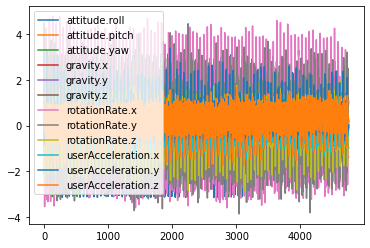

In [13]:
temp.plot()

Time to see results
Windows do not overlap so there is no data leakage between windows so we can take random split.

In [14]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(raw_data.drop(["label"], axis=1).fillna(0),
                                                                    raw_data["label"],
                                                                    test_size=0.2, 
                                                                    random_state=42)
X_train_proc, X_test_proc, y_train_proc, y_test_proc = train_test_split(post_data.drop(["label"], axis=1).fillna(0),
                                                                    post_data["label"],
                                                                    test_size=0.2, 
                                                                    random_state=42)

For check two methods will be used: SVC and Random Forest, all with the same parameters and most parameters was set to default. Only Random Forest were modified so it won't get too deep.

In [15]:
%%time
lsvc_raw = LinearSVC(random_state=42)
lsvc_raw.fit(X_train_raw, y_train_raw)
score_raw = lsvc_raw.score(X_test_raw, y_test_raw)
print("Score of raw: ", score_raw)

Score of raw:  0.6870881567230632
Wall time: 2min 9s


In [16]:
%%time
lsvc_proc = LinearSVC(random_state=42)
lsvc_proc.fit(X_train_proc, y_train_proc)
score_proc = lsvc_proc.score(X_test_proc, y_test_proc)
print("Score of processed: ", score_proc)

Score of processed:  0.9561887800534283
Wall time: 25.8 s


In [17]:
%%time
rf_raw = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_raw.fit(X_train_raw, y_train_raw)
score_raw = rf_raw.score(X_test_raw, y_test_raw)
print("Score of raw: ", score_raw)

Score of raw:  0.9200356188780053
Wall time: 30.8 s


In [18]:
%%time
rf_proc = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_proc.fit(X_train_proc, y_train_proc)
score_proc = rf_proc.score(X_test_proc, y_test_proc)
print("Score of processed: ", score_proc)

Score of processed:  0.9720391807658059
Wall time: 11.8 s


# Summary:
If we take lag features we go for faster with preprocessing data, however in this case we got 600 columns without label. Using the feature extraction reduced the amount of columns to 156. This also has significant impact on training time, which is much shorter in case of more complex feature extraction. However, it is wort to mention RF did much better job using raw data than LinearSVC. In both cases feature engineering improved results.